# Example of usage

## TO DO
 - ~~Read https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6080751~~ 
 - ~~Implement Spectral Angle Metric~~
 - ~~Fix: Images are being read in an improper order depending on code~~
 - ~~Test different pixel formats~~
 - ~~Implement uint16 to uint10le and backwards: Let's just use np.uint16 and make sure that numbers don't exceed the maximum of 10/12 bits!!~~
 - ~~Implement planar support~~
 - ~~Implement rgb to bgr, etc.~~
 - Download and assess ERA5 / Other high-res climate datasets:
   - https://deepesdl.readthedocs.io/en/latest/datasets/ESDC/
   - ~~https://weatherbench2.readthedocs.io/en/latest/data-guide.html#era5~~
   - ~~https://github.com/google-research/arco-era5~~
 - Improve satalign
 - ~~Create function to create a compression recipe automatically from a cube~~
 - ~~Try KLT (Karhunen-Loève Transform, also known as PCA before compressing~~
 - ~~Implement automatic channel fusion, when the data has more than 1 extra dimension~~
 - Add baseline curves (not the main ones, but other set of results!):
   - ~~Frame-by-frame jpeg 2000 `-c:v jpeg2000 output_%04d.jp2` or better: `-c:v jpegxl output_%04d.jxl`~~
   - With / without cloud-filling
   - With / without alignment
   - With / wihtout PCA
 - ~~Finish quick implementation and use SSIM / FSIM for the plots: https://www4.comp.polyu.edu.hk/~cslzhang/IQA/TIP_IQA_FSIM.pdf~~
 - ~~Add MS-SSIM for the plots: https://lightning.ai/docs/torchmetrics/stable/image/multi_scale_structural_similarity.html~~
 
TODO for real:
 
 - Write paper: A library for hyperspectral spatio-temporal imagery compression with standard video codecs / Exploring 4D data compression
 - MAYBE: Integrate into mlstack if sensible
 - MAYBE: Create a video-dataset of deepextremes
 
## Others
 - Read more literature: 
   - https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/ipr2.12077
 - For complex input formats (e.g. yuv444p, etc.) do ffv1 as intermediate format! > Could fix our vp9 for yuva444p10le problems

In [3]:
#Autoreload .py files
%load_ext autoreload
%autoreload 2

#https://github.com/chmp/ipytest/issues/80
import sys
sys.breakpointhook = sys.__breakpointhook__

Load required libraries

In [4]:
import xarray as xr
import numpy as np
from pathlib import Path
from xarrayvideo import xarray2video, video2xarray, gap_fill, plot_image, to_netcdf
import matplotlib.pyplot as plt

/home/oscar/.conda/envs/xv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set up some variables and load an example minicube

In [5]:
array_id= '-111.49_38.60'
input_path= '../mc_-111.49_38.60_1.2.2_20230702_0.zarr'
output_path= './out'
use_B07= True

In [110]:
minicube= xr.open_dataset(input_path, engine='zarr')
minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
minicube['cloudmask_en']= minicube['cloudmask_en'].astype(np.uint8)
if not use_B07: minicube= minicube.drop_vars('B07') #We drop a variable for now

In [111]:
minicube

<xarray.Dataset> Size: 471MB
Dimensions:       (time: 495, y: 128, x: 128, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 18kB 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 4kB 2016-01-03T12:00:00 ... 2022-10-0...
  * x             (x) float64 1kB 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 72B 9.785e+05 9.788e+05 ... 9.809e+05
  * y             (y) float64 1kB 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 72B 4.288e+06 4.287e+06 ... 4.285e+06
Data variables: (12/38)
    B02           (time, y, x) float64 65MB ...
    B03           (time, y, x) float64 65MB ...
    B04           (time, y, x) float64 65MB ...
    B05           (time, y, x) float64 65MB ...
    B06           (time, y, x) float64 65MB ...
    B07           (time, y, x) float64 65MB ...
    ...            ...
    t2m_max       (time) float32 2kB ...
    t2m_mean      (time) float32 2kB ...
    t2m_min       (time) float32 2kB ...
    tp_max        (time) float32 2kB ...
    tp_mean       (time) float32 2kB ...
    tp_min        (time) float32 2kB ...
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

Fix the small jitter betweeen timesteps to improve compression

In [112]:
import satalign, satalign.ecc, satalign.pcc

#Reload minicube for testing
minicube= xr.open_dataset(input_path, engine='zarr')
minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
if not use_B07: minicube= minicube.drop_vars('B07') #We drop a variable for now

bands= ['B04','B03','B02','B8A','B06','B05'] + (['B07'] if use_B07 else [])
reference_image= minicube[bands].isel(time=slice(74,None)).mean("time").to_array().transpose('variable', 'y', 'x')
datacube= minicube[bands].to_array().transpose('time', 'variable', 'y', 'x')

syncmodel= satalign.pcc.PCC( #PCC quicker, ECC more precise
    datacube=datacube, # T x C x H x W
    reference=reference_image, # C x H x W
    channel="mean", crop_center=96, num_threads=1)
new_cube, warps= syncmodel.run_multicore()

#Plot scatter plot
warp_df = satalign.utils.warp2df(warps, datacube.time.values)
satalign.utils.plot_s2_scatter(warp_df)

#Copy back
# for b in bands: minicube[b]= new_cube.sel(variable=b)

/home/oscar/satalign/satalign/pcc.py:79: UserWarning: Could not determine RMS error between images with the normalized average intensities 9649194.526800724 and 0.0. Either the reference or moving image may be empty.
  shift, error, diffphase = phase_cross_correlation(
/home/oscar/satalign/satalign/main.py:240: UserWarning: Estimated translation is too large
  warnings.warn("Estimated translation is too large")


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

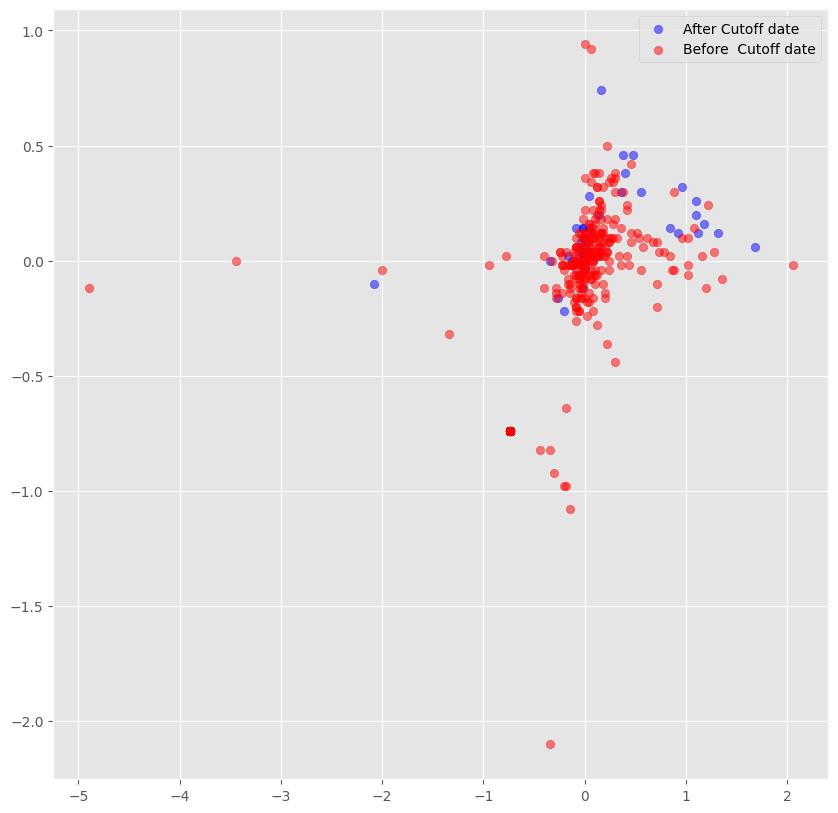

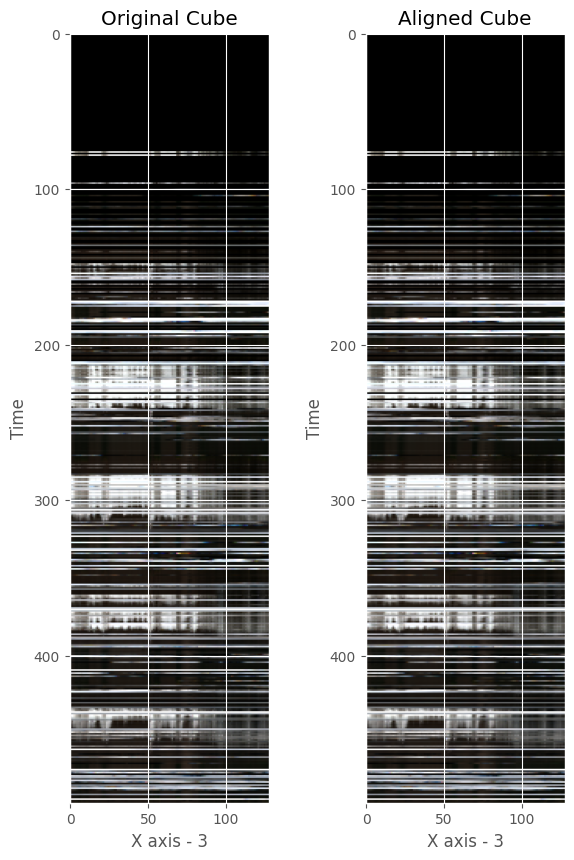

In [113]:
satalign.utils.plot_profile(
    warped_cube=new_cube.values,
    raw_cube=datacube.values,
    x_axis=3,
    rgb_band=[0,1,2],
    intensity_factor=1.,
    figsize= (7,10)
)
plt.show()

Gap-fill in clouds

For now, we won't apply gap-filling of the clouds, since it is too big of a change to the data. If a good gap-filling algorithm were to be used, we could save up much more space when converting to video

In [114]:
#Perform the gap filling. Three methods: last_value, interp_forward, interp (non-causal!!)
minicube_filled= gap_fill(minicube, fill_bands=bands, mask_band='cloudmask_en',
                          fill_values=[1, 3, 4], method='last_value', new_mask='invalid', 
                          coord_names=('time', 'variable', 'y', 'x'))

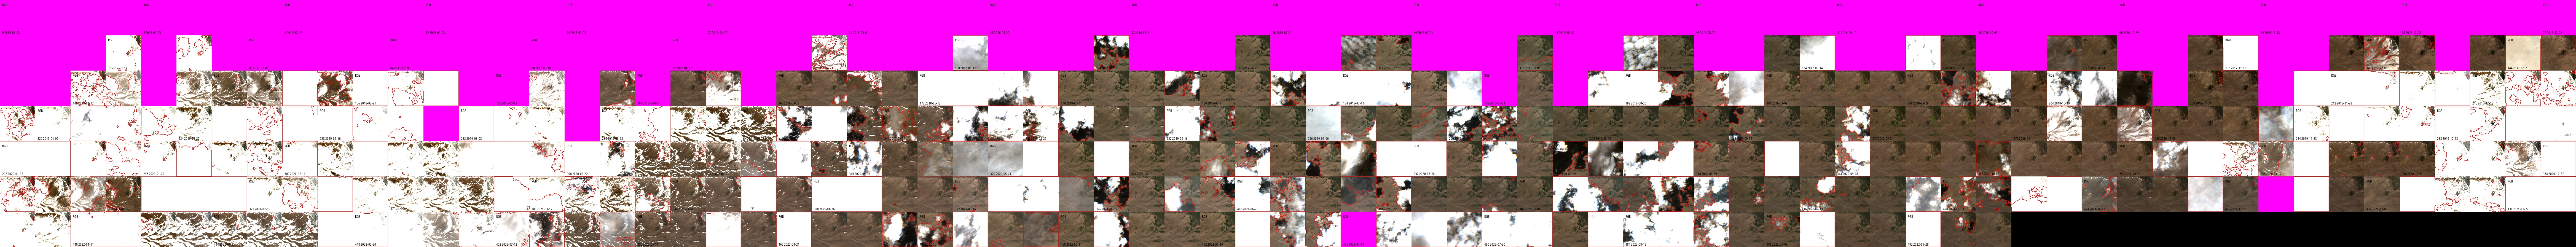

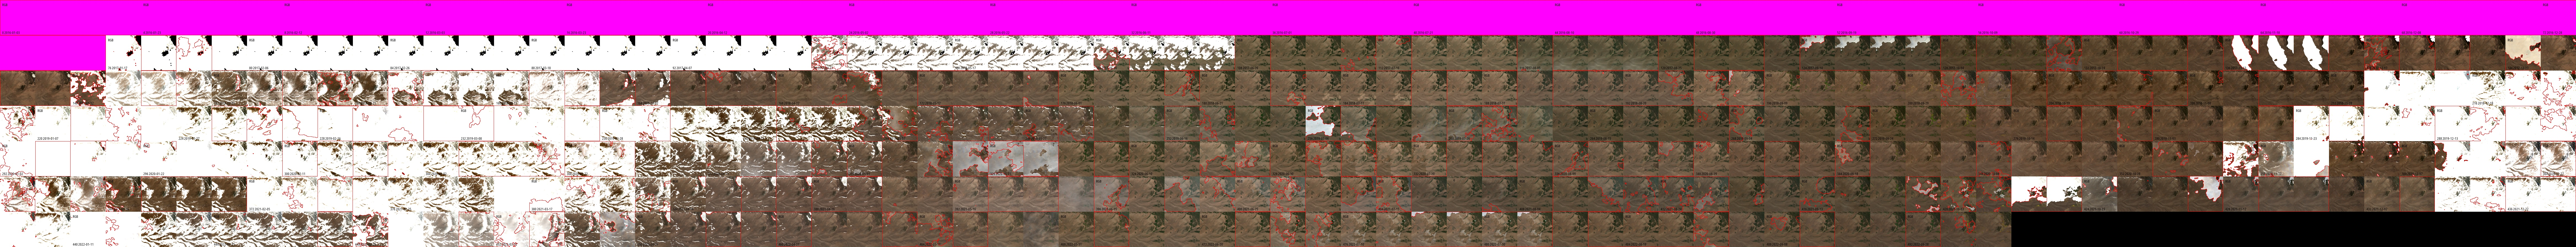

In [115]:
#RGB orig
plot_image(minicube, ['B04','B03','B02'], mask_name='cloudmask_en', save_name='./out/RGB original.jpg')

#RGB gap-filled
plot_image(minicube_filled, ['B04','B03','B02'], mask_name='invalid', save_name='./out/RGB gap-filled.jpg')

In [116]:
minicube

<xarray.Dataset> Size: 471MB
Dimensions:       (time: 495, y: 128, x: 128, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 18kB 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 4kB 2016-01-03T12:00:00 ... 2022-10-0...
  * x             (x) float64 1kB 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 72B 9.785e+05 9.788e+05 ... 9.809e+05
  * y             (y) float64 1kB 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 72B 4.288e+06 4.287e+06 ... 4.285e+06
Data variables: (12/38)
    B02           (time, y, x) float64 65MB 0.0 0.0 0.0 ... 0.0549 0.0648 0.0646
    B03           (time, y, x) float64 65MB 0.0 0.0 0.0 ... 0.0724 0.0817 0.083
    B04           (time, y, x) float64 65MB 0.0 0.0 0.0 ... 0.0893 0.1026 0.1059
    B05           (time, y, x) float64 65MB 0.0 0.0 0.0 ... 0.1084 0.1216 0.1241
    B06           (time, y, x) float64 65MB 0.0 0.0 0.0 ... 0.131 0.1457 0.1439
    B07           (time, y, x) float64 65MB 0.0 0.0 0.0 ... 0.1483 0.1573 0.1538
    ...            ...
    t2m_max       (time) float32 2kB ...
    t2m_mean      (time) float32 2kB ...
    t2m_min       (time) float32 2kB ...
    tp_max        (time) float32 2kB ...
    tp_mean       (time) float32 2kB ...
    tp_min        (time) float32 2kB ...
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

Since we are basically using `ffmpeg` for the enconding, here are some important commands

In [117]:
#!ffmpeg -codecs

In [118]:
#Get info of a particular encoder
!ffmpeg -h encoder=jpeg2000 -v quiet #vp9, libx264, libx265, ffv1, prores_ks, dnxhd

Encoder jpeg2000 [JPEG 2000]:
    General capabilities: none
    Threading capabilities: none
    Supported pixel formats: rgb24 yuv444p gray yuv420p yuv422p yuv410p yuv411p pal8 rgb48le gray16le
jpeg 2000 encoder AVOptions:
  -format            <int>        E..V....... Codec Format (from 0 to 1) (default jp2)
     j2k             0            E..V.......
     jp2             1            E..V.......
  -tile_width        <int>        E..V....... Tile Width (from 1 to 1.07374e+09) (default 256)
  -tile_height       <int>        E..V....... Tile Height (from 1 to 1.07374e+09) (default 256)
  -pred              <int>        E..V....... DWT Type (from 0 to 1) (default dwt97int)
     dwt97int        0            E..V.......
     dwt53           0            E..V.......
  -sop               <int>        E..V....... SOP marker (from 0 to 1) (default 0)
  -eph               <int>        E..V....... EPH marker (from 0 to 1) (default 0)
  -prog              <int>        E..V....... Progression O

Compress and write new file

If you get `ContainsGroupError`, make sure to delete the existing `out` folder:

In [119]:
#Remove out folder to avoid errors
!rm -rf ./out

Define conversion rules for the different bands. The syntax is:
```
{
 'video_name_1': ( 
    var or (var1, var2, var3), #Variables present in the xarray
    (t_coord_name, x_coord_name, y_coord_name), #Names of the coordinates in order (t, x, y)
    [Optional] n_components: 0 or n_components 
        - 0: store all bands in sets of 3 channels, last video might only have 1 or 2 channels (less efficient)
        - n_components: store all bands using n_components, which must be divisable by 3
    [Optional] compression parameters dictionary:  
       {
        'c:v': 'libx265',  #[libx264, libx265, vp9, ffv1]
        'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
        'crf': 3, #3 default, the lower, the higher the quality
        'x265-params': 'qpmin=0:qpmax=5:psy-rd=0:psy-rdoq=0' #qpmax controls the quality when crf is 0
       },
    [Optional] number of bits (e.g.: 8,10,12,16),
    ),
 'video_name_2': etc
}
```

In [120]:
#Save original minicube for comparing the size (it will be compressed)
Path(output_path).mkdir(exist_ok=True, parents=True)
#minicube.to_zarr(Path(output_path) / f'{array_id}.zarr')
to_netcdf(minicube, Path(output_path) / f'{array_id}.nc')

In [125]:
#Define the output video encoding parameters.

#Video lossless
#Best for lossless 1-channel: ffv1
lossless_params= { 'c:v':'ffv1' }
#Best for lossless 3-channel: vp9
# lossless_params= {'c:v':'vp9', 'lossless':1, 'deadline':'good'} #good, best, realtime

#Video lossy 
#Best for lossy 3-channel: libx265, 12 bits
#Psychovisual Rate-Distortion Optimization (Psy-RD) is a technique used in video encoding 
#that adjusts the bit allocation and quantization to improve the perceived visual quality 
#of the encoded video. This method takes into account the human visual system's sensitivity 
#to different types of distortions and allocates more bits to areas that are more noticeable 
#to the human eye, such as edges and textures, while compressing other areas more aggressively
# -> We disable those optimizations!
lossy_params= {
    'c:v': 'libx265',  #[libx264, libx265, vp9, ffv1] #Test: -c:v jpegxl output_%04d.jxl
    'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': [1], #14 default, 11 for higher quality and size
    # 'tune': 'ssim', #ssim, psnr
    # 'x265-params': 'no-sao:selective-sao=0',
    'x265-params': ['qpmin=0:qpmax=0.1:psy-rd=0:psy-rdoq=0', #:lookahead-frames=25
                    'qpmin=0:qpmax=1:psy-rd=0:psy-rdoq=0',   #When using a low qpmax, basically crf is 100% ignored
                    'qpmin=0:qpmax=10:psy-rd=0:psy-rdoq=0'], #Usually with crf=0 this is around 4-8, sot set higher to go <0
    # "lookahead-slices=1"
    #psy-rd=0:psy-rdoq=0
    }
# lossy_params= {
#     'c:v': 'vp9',
#     'crf': 3,
#     'arnr-strength': 2,
#     # 'qmin': 0,
#     # 'qmax': 3,
#     'lag-in-frames': 25,
#     'arnr-maxframes': 7,
#     }

#Image lossy / lossless
image_lossy_params= {
    'codec': 'JP2OpenJPEG',
    'QUALITY': '25', #100 for lossless, less than that for lossy
    # 'REVERSIBLE': 'YES',  #YES for lossless
    'YCBCR420':'NO',
    'WRITE_METADATA': 'NO'
    }

image_lossless_params= {
    'codec': 'JP2OpenJPEG',
    'QUALITY': '100', #100 for lossless, less than that for lossy
    'REVERSIBLE': 'YES',  #YES for lossless
    'YCBCR420':'NO',
    'WRITE_METADATA': 'NO'
    }

#Define conversion rules for the different bands
#We can manually choose how to compress the different bands
conversion_rules= {    
#     #Sets of 3 channels are the most efficient for lossy compression
    # 'rgb': ( ('B04','B03','B02'), ('time','x','y'), 0, lossy_params, 8), #[0, 0.4]
    # 'ir3': ( ('B8A','B06','B05'), ('time','x','y'), 0, lossy_params, 10),
    
#     #Compressing 1 channel lossy is not efficient, as it just repeats the channel 3 times
#     'r': ( 'B04', ('time','x','y'), 0, lossy_params, 10),
    
#     #Compressing 1,3, or 4 channels losslessly is efficient
#     'cm': ( 'cloudmask_en', ('time','x','y'), 0, lossless_params, 8),
#     'scl': ( 'SCL', ('time','x','y'), 0, lossless_params, 8),
    }
    
#There are also automatic modes for encoding many bands at once
conversion_rules= {
#     #We can do PCA and keep a subset of principal components (e.g. 6)
    #'B04','B03','B02','B8A'
    'all': ( ('B07', 'B06','B05'), ('time','x','y'), 0, lossy_params, 10),
    
    # We can pass all the bands, NOT do PCA, and repeat any bands if needed so that they are divisible by 3
    # 'all2': ( ('B07','B06','B05','B04','B03','B02','B8A'), ('time','x','y'), 0, image_lossy_params, 16),
    
    # Compressing 1,3, or 4 channels losslessly is efficient
    # 'scl': ( 'SCL', ('time','x','y'), 0, lossless_params, 8),
    # 'cm': ( 'cloudmask_en', ('time','x','y'), 0, lossless_params, 8),
    }

Error writing trailer of out/-111.49_38.60/all_001.mkv: Immediate exit requested
frame=  409 fps= 12 q=2.0 Lsize=    2048kB time=00:00:13.60 bitrate=1233.5kbits/s speed=0.385x    
video:2310kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
Input file #0 (pipe:):
  Input stream #0:0 (video): 409 packets read (40206336 bytes); 409 frames decoded; 
  Total: 409 packets (40206336 bytes) demuxed
Output file #0 (out/-111.49_38.60/all_001.mkv):
  Output stream #0:0 (video): 409 frames encoded; 409 packets muxed (2365148 bytes); 
  Total: 409 packets (2365148 bytes) muxed
[AVIOContext @ 0x556af80c0a40] Statistics: 2097152 bytes written, 2 seeks, 11 writeouts
Error closing file out/-111.49_38.60/all_001.mkv: Immediate exit requested
[AVIOContext @ 0x556af80a3600] Statistics: 40206336 bytes read, 0 seeks
Exiting normally, received signal 2.


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

all: 185.62Mb -> ['8.33']Mb (showing last 10)(4.49% of original size, 2.8723 bpppb) in 15.05s
 - params={'c:v': 'libx265', 'preset': 'medium', 'crf': [1], 'x265-params': ['qpmin=0:qpmax=0.1:psy-rd=0:psy-rdoq=0:lossless=1', 'qpmin=0:qpmax=1:psy-rd=0:psy-rdoq=0:lossless=1', 'qpmin=0:qpmax=10:psy-rd=0:psy-rdoq=0:lossless=1']}
 - Decompression time 0.39s


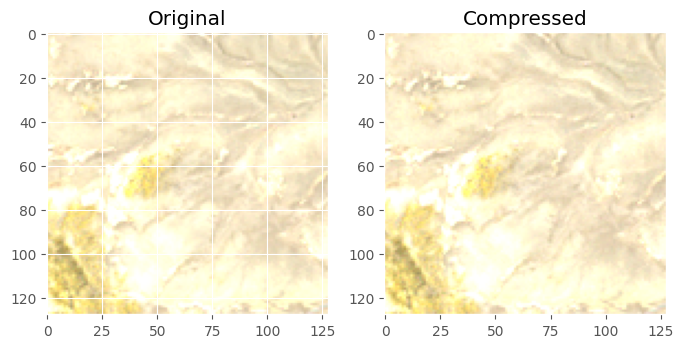

Saturation values per band ('B07', 'B06', 'B05')):
 [[0.     1.5684]
 [0.     1.5788]
 [0.     1.5902]]
 - SSIM_sat 0.999758
 - MSE_sat 0.000001
 - PSNR_sat 64.7740
 - Exp. SA 0.0024 
Metrics took 2.44s to run


In [126]:
#Run with compute_stats (takes a bit longer)
arr_dict= xarray2video(minicube, array_id, conversion_rules, fmt='auto',
                       output_path=output_path, compute_stats=True,
                       loglevel='verbose', #verbose, quiet
                       save_dataset= False
                       )  

In [123]:
#!ffprobe -v error -show_format -show_streams out/-111.49_38.60/all2_001.mkv

Compute total size, and observe a signficant compression rate (~25x)

In [18]:
original_path= str(Path(output_path) / f'{array_id}.nc')
!du -h {original_path} -d0

456M	out/-111.49_38.60.nc


In [19]:
new_path= str(Path(output_path) / f'{array_id}')
!du -h {new_path} 

8,8M	out/-111.49_38.60


Read again the written file, and check that everything has persisted

In [20]:
minicube_new= video2xarray(output_path, array_id) 
minicube_new

FileNotFoundError: [Errno 2] No such file or directory: b'/home/oscar/xarrayvideo/out/-111.49_38.60/x.nc'

Visualize results

In [ ]:
#RGB
plot_image(minicube, ['B04','B03','B02'], save_name='./out/RGB original.jpg')
plot_image(minicube_new, ['B04','B03','B02'], save_name='./out/RGB compressed.jpg')

In [ ]:
#R3
plot_image(minicube, ['B8A','B06','B05'], save_name='./out/R3 original.jpg')
plot_image(minicube_new, ['B8A','B06','B05'], save_name='./out/R3 compressed.jpg')

In [ ]:
#Cloudmask
plot_image(minicube, ['cm'], plot_idx=[[0]], save_name='./out/CM original.jpg')
plot_image(minicube_new, ['cm'], plot_idx=[[0]], save_name='./out/CM compressed.jpg')

In [ ]:
#Gray
# plot_image(minicube, ['B07'], plot_idx=[[0]], save_name='./out/Gray original.jpg')
# plot_image(minicube_new, ['B07'], plot_idx=[[0]], save_name='./out/Gray compressed.jpg')

In [ ]:
#RGBA
# plot_image(minicube, ['B8A','B07','B06','B05'], plot_idx=[[0],[1],[2],[3]], save_name='RGBA original.jpg')
# plot_image(minicube_new, ['B8A','B07','B06','B05'], plot_idx=[[0],[1],[2],[3]], save_name='RGBA compressed.jpg')
# txy_real_rgba_compressed= np.transpose(arr_dict['ir4'][0], (3,0,1,2)) #t,x,y,3 -> 4,t,x,y

Watch as a video (some formats might not be supported)

In [ ]:
from IPython.display import Video, display, HTML, Image
for video in conversion_rules.keys():
    path= Path(output_path) / array_id / f'{video}.mkv'
    display(HTML(f'<h4>{video}</h4>{path}'))
    # display(HTML(f"""
    # <video width="512" height="512" controls>
    #   <source src="{path}">
    # </video>
    # """))
    display(Video(path, width=512, height=512, embed=True))

In [ ]:
assert False

## Use for climate data

In [ ]:
# era5_version= '1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr' #623Tb
era5_version= '1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr' #80Tb
# era5_version= '1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr' #2Tb
# era5_version= '1959-2023_01_10-6h-64x32_equiangular_conservative.zarr' #163Gb

In [ ]:
era5= xr.open_zarr(f'gs://weatherbench2/datasets/era5/{era5_version}') 
print(f'Size: {era5.nbytes / 2**30:.3f}Gb')
era5

In [ ]:
#Choose a subset of the dataset
import pandas as pd
start= '2022-07-01'
data_from_start_date= era5.sel(time=slice(pd.Timestamp(start), None))

#Save
#data_from_start_date.to_zarr(f'since_{start}_{era5_version}')

In [ ]:
import pandas as pd

#Open from local
era5_version= '../since_2022-07-01_1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr' #80Tb
era5_version= '../since_2022-07-01_2022-07-01_1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
# era5_version= '../1959-2023_01_10-6h-64x32_equiangular_conservative.zarr' #163Gb

era5= xr.open_dataset(era5_version, engine='zarr')
print(f'Size: {era5.nbytes / 2**30:.3f}Gb')
era5

In [ ]:
era5['relative_humidity'].isel({'time':50, 'level':12}).plot()

In [ ]:
list(era5.variables)

In [ ]:
#We can get generic conversion rules (which might be suboptimal)
from xarrayvideo import get_recipe
from pprint import pprint as pp
conversion_rules= get_recipe(era5, t='time', x='longitude', y='latitude', c='level', bits=10)
pp(conversion_rules)

In [ ]:
#Ideally, we want to manually optimize the recipe
lossy_params = {
    'c:v': 'libx265',  #[libx264, libx265, vp9, ffv1]
    'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': [0],#,1,3,6,9], #14 default, 11 for higher quality and size
    'x265-params': 'qpmin=0:qpmax=0.001:psy-rd=0:psy-rdoq=0',
    }

conversion_rules= {
    'wind': ( ('10m_u_component_of_wind', '10m_v_component_of_wind', '10m_wind_speed'), ('time', 'longitude', 'latitude'), 
             0, lossy_params, 10),
    # 'wind_speed': ('wind_speed', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    # # 'wind_speed2': ('wind_speed', ('time', 'longitude', 'latitude', 'level'), 12, lossy_params, 10),
    'relative_humidity': ('relative_humidity', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    'wind_speed': ('wind_speed', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    'wind_u': ('u_component_of_wind', ('time', 'longitude', 'latitude', 'level'), 0, lossy_params, 10),
    }

In [ ]:
arr_dict= xarray2video(era5.sel(time=slice(pd.Timestamp('2022-11-01'), None)), 
                       era5_version.replace('.zarr', ''), conversion_rules,
                       output_path=output_path, use_ssim=False, compute_stats=True,
                       loglevel='verbose', #verbose, quiet
                       save_dataset=False #Disable saving
                       )  

## Testing Cesar's cloudless data

In [24]:
#Load data
import pandas as pd
data= np.load('../s2data.npy')
cesar_bands= ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

#Create the xarray.DataArray
xdata= xr.Dataset(
    {band: ( ['time', 'x', 'y'], data[:,bi] ) for bi,band in enumerate(cesar_bands)},
    coords={
        'time': pd.date_range("2015-09-01", periods=106, freq='ME'),
        'x': np.arange(512),
        'y': np.arange(512),
    },
)

xdata= xdata.astype(np.float32) / 10000.
xdata

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 106, x: 512, y: 512)
Coordinates:
  * time     (time) datetime64[ns] 848B 2015-09-30 2015-10-31 ... 2024-06-30
  * x        (x) int64 4kB 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511
  * y        (y) int64 4kB 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511
Data variables:
    B2       (time, x, y) float32 111MB 0.0556 0.0531 0.0495 ... 0.1101 0.1362
    B3       (time, x, y) float32 111MB 0.059 0.0825 0.0775 ... 0.1251 0.1528
    B4       (time, x, y) float32 111MB 0.084 0.1071 0.1026 ... 0.1378 0.2051
    B5       (time, x, y) float32 111MB 0.1479 0.1941 0.1937 ... 0.268 0.248
    B6       (time, x, y) float32 111MB 0.1581 0.1341 0.1314 ... 0.1625 0.2081
    B7       (time, x, y) float32 111MB 0.1367 0.1629 0.1634 ... 0.2154 0.2487
    B8       (time, x, y) float32 111MB 0.1616 0.1781 0.1789 ... 0.2503 0.2827
    B8A      (time, x, y) float32 111MB 0.1934 0.2091 0.2087 ... 0.28 0.3216
    B11      (time, x, y) float32 111MB 0.2813 0.3312 0.3281 ... 0.256 0.2738
    B12      (time, x, y) float32 111MB 0.2103 0.2337 0.2299 ... 0.1836 0.1826

In [26]:
lossy_params = {
    'c:v': 'libx265',  #[libx264, libx265, vp9, ffv1]
    'preset': 'medium',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': [50],#,1,3,6,9], #14 default, 11 for higher quality and size
    'x265-params': 'qpmin=0:qpmax=0.1:psy-rd=0:psy-rdoq=0',
    }
image_lossy_params= {
    'codec': 'JP2OpenJPEG',
    'QUALITY': '5', #100 for lossless, less than that for lossy
    # 'REVERSIBLE': 'YES',  #YES for lossless
    'YCBCR420':'NO',
    'WRITE_METADATA': 'NO'
    }

conversion_rules= {
    # 'rgb': (['B4', 'B3', 'B2'], ('time', 'x', 'y'), 0, lossy_params, 10),
    
    # 'all': (cesar_bands, ('time', 'x', 'y'), 0, lossy_params, 10), #Using video
    # 'all': (cesar_bands, ('time', 'x', 'y'), 9, lossy_params, 10), #Using video with PCA
    'all': (cesar_bands, ('time', 'x', 'y'), 0, image_lossy_params, 16), #Using image
    }

arr_dict= xarray2video(xdata, 'cesar', conversion_rules,
                       output_path=output_path, compute_stats=True,
                       loglevel='verbose', #verbose, quiet
                       save_dataset=False #Disable saving?
                       )  

Writing out/cesar/all_{id}.jp2:  15%|█▌        | 16/106 [00:03<00:17,  5.11it/s]

KeyboardInterrupt



In [ ]:
new_path= str(Path(output_path) / 'cesar')
!du -h {new_path} 

Read again the written file, and check that everything has persisted

In [ ]:
xdata_new= video2xarray(output_path, 'cesar', x_name='x', y_name='y', transpose=False) 
xdata_new

Visualize results

In [ ]:
#RGB
plot_image(xdata, ['B4','B3','B2'], mask_name=None, stack_every=12, save_name='./out/RGB original_cesar.jpg')
plot_image(xdata_new, ['B4','B3','B2'], mask_name=None, stack_every=12, save_name='./out/RGB compressed_cesar.jpg')

## Plot some compression graphs for DeepExtremes

In [ ]:
raise None

In [ ]:
#Remove out folder to avoid errors
!rm -rf ./testing

In [ ]:
#assert False, 'Comment this cell to run. This takes a long time'

#Load libs
from tqdm import tqdm
import warnings, shutil
import pandas as pd
rng= np.random.default_rng(seed=42)

#Global config
DEBUG= False
DATASET= 'cesar' #One of ['deepextremes', 'cesar', 'era5']
RULES_NAME= '10channels' #'11channels', '7channels', etc., just for save name

if DATASET == 'deepextremes':
    #Take N random cubes
    dataset_in_path= Path('/scratch/users/databases/deepextremes/deepextremes-minicubes/full')
    cube_paths= np.array(list(dataset_in_path.glob('*/*.zarr'))) #'*/*.zarr'
    rng.shuffle(cube_paths)
    cube_paths= cube_paths[:12]
elif DATASET == 'cesar':
    cube_paths= [Path('../s2data.npy')]
elif DATASET == 'era5':
    cube_paths= [Path(
    '../since_2022-07-01_2022-07-01_1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr')]    
else:
    raise RuntimeError(f'Unknown {DATASET=}')
    
#Define all tests
tests= ['libx265', 'vp9', 'JP2OpenJPEG']
#['libx264_slow_ffv1', 'libx265_medium_ffv1', 'vp9_quick_vp9']
crfs= ['Best','Very high','High','Medium','Low','Very low']
x265_params= [
    {'c:v': 'libx265', 'preset':'medium', 'crf': 51, 'x265-params':'lossless=1'},
    {'c:v': 'libx265', 'preset':'medium', 'crf': 51, 
     'x265-params':'qpmin=0:qpmax=0.0000001:psy-rd=0:psy-rdoq=0'},
    {'c:v': 'libx265', 'preset':'medium', 'crf': 51, 
     'x265-params':'qpmin=0:qpmax=0.01:psy-rd=0:psy-rdoq=0'},
    {'c:v': 'libx265', 'preset':'medium', 'crf': 51, 
     'x265-params':'qpmin=0:qpmax=0.1:psy-rd=0:psy-rdoq=0'},
    {'c:v': 'libx265', 'preset':'medium', 'crf': 1, 'x265-params':'psy-rd=0:psy-rdoq=0'},
    {'c:v': 'libx265', 'preset':'medium', 'crf': 10, 'x265-params':'psy-rd=0:psy-rdoq=0'},
  ]
vp9_params= [
    {'c:v': 'vp9', 'crf': 0, 'lossless': 1},
    {'c:v': 'vp9', 'crf': 0, 'arnr-strength': 2, 'qmin': 0, 'qmax': 0.0001, 
     'lag-in-frames': 25, 'arnr-maxframes': 7},
    {'c:v': 'vp9', 'crf': 0, 'arnr-strength': 2, 'qmin': 0, 'qmax': 0.01, 
     'lag-in-frames': 25, 'arnr-maxframes': 7},
    {'c:v': 'vp9', 'crf': 1, 'arnr-strength': 2, 'qmin': 0, 'qmax': 1, 
     'lag-in-frames': 25, 'arnr-maxframes': 7},
    {'c:v': 'vp9', 'crf': 5, 'arnr-strength': 2, 'lag-in-frames': 25, 'arnr-maxframes': 7},
    {'c:v': 'vp9', 'crf': 12, 'arnr-strength': 2, 'lag-in-frames': 25, 'arnr-maxframes': 7},
  ]
jpeg2000_params= [
    {'codec': 'JP2OpenJPEG', 'QUALITY': '100', 'REVERSIBLE': 'YES', 'YCBCR420':'NO'}, 
    {'codec': 'JP2OpenJPEG', 'QUALITY': '100', 'REVERSIBLE': 'NO', 'YCBCR420':'NO'},
    {'codec': 'JP2OpenJPEG', 'QUALITY': '75', 'REVERSIBLE': 'NO', 'YCBCR420':'NO'},
    {'codec': 'JP2OpenJPEG', 'QUALITY': '35', 'REVERSIBLE': 'NO', 'YCBCR420':'NO'},
    {'codec': 'JP2OpenJPEG', 'QUALITY': '15', 'REVERSIBLE': 'NO', 'YCBCR420':'NO'},
    {'codec': 'JP2OpenJPEG', 'QUALITY': '5', 'REVERSIBLE': 'NO', 'YCBCR420':'NO'},
  ]
codec_params= dict(zip(tests, [x265_params, vp9_params, jpeg2000_params]))
n_bits= [8,10,12,16]

#Run
overall_results={}
for input_path in (pbar:=tqdm(cube_paths, total=len(cube_paths))):
    #Load data
    if DATASET == 'deepextremes':
        array_id= '_'.join(input_path.stem.split('_')[1:3])
        minicube= xr.open_dataset(input_path, engine='zarr')
        minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
        minicube['cloudmask_en']= minicube['cloudmask_en'].astype(np.uint8)
        # minicube= minicube.drop_vars('B07') #We drop a variable for now

        #Align
        bands= ['B04','B03','B02','B8A','B06','B05','B07']
        minicube= minicube.isel(time=slice(74*2,None)) #First two years > missing data
        reference_image= minicube[bands].mean("time").to_array().transpose('variable', 'y', 'x')
        datacube= minicube[bands].to_array().transpose('time', 'variable', 'y', 'x')
        with warnings.catch_warnings(): 
            warnings.simplefilter("ignore")
            syncmodel= satalign.pcc.PCC( #PCC quicker, ECC more precise
                datacube=datacube, # T x C x H x W
                reference=reference_image, # C x H x W
                channel="mean", crop_center=96, num_threads=1)
            new_cube, warps= syncmodel.run_multicore()
            for b in bands: minicube[b]= new_cube.sel(variable=b)
    elif DATASET == 'cesar':
        data= np.load(input_path)
        cesar_bands= ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
        minicube= xr.Dataset(
            {band: ( ['time', 'x', 'y'], data[:,bi] ) for bi,band in enumerate(cesar_bands)},
            coords={
                'time': pd.date_range("2015-09-01", periods=106, freq='ME'),
                'x': np.arange(512),
                'y': np.arange(512),
            },
        )
        minicube= minicube.astype(np.float32) / 10000.
        array_id= 'cesar_0'
    elif DATASET == 'era5':
        era5= xr.open_dataset(input_path, engine='zarr')
        minicube= era5.sel(time=slice(pd.Timestamp('2022-11-01'), None)) #Choose small time subset
        array_id= 'ERA5_0'
        print(f'Size: {era5.nbytes / 2**30:.3f}Gb')
    else:
        raise RuntimeError(f'Unknown {DATASET=}')
        
    #Save cube id
    overall_results[array_id]= {}

    #Run tests
    for test, codec_param in codec_params.items():
        overall_results[array_id][test]= {}
        for crf, param in zip(crfs, codec_param, strict=False):
            overall_results[array_id][test][crf]= {}
            for bits in n_bits:
                #Update pbar
                pbar.set_description(f'{test=} | {array_id=} | {crf=} | {bits=}')

                #Skip bits that are not possible for a given codec
                if test != 'JP2OpenJPEG':
                    if bits not in [8,10,12]: continue
                else:
                    if bits not in [8,16]: continue
                
                if DATASET == 'deepextremes':
                    conversion_rules= {
                        '7 bands': ( ('B07','B06','B05','B04','B03','B02','B8A'), 
                                    ('time','x','y'), False, param, bits),
                        # 'rgb': ( ('B04','B03','B02'), ('time','x','y'), False, param, bits),
                        # 'ir3': ( ('B8A','B06','B05'), ('time','x','y'), False, param, bits),
                        }
                elif DATASET == 'cesar':
                    conversion_rules= {
                        # 'rgb': (['B4', 'B3', 'B2'], ('time', 'x', 'y'), False, param, bits),
                        'all': (cesar_bands, ('time', 'x', 'y'), False, param, bits),
                        }
                elif DATASET == 'era5':
                    conversion_rules= {
                    # 'wind': ( ('10m_u_component_of_wind', '10m_v_component_of_wind', '10m_wind_speed'), 
                    #           ('time', 'longitude', 'latitude'), False, param, bits),
                    # 'relative_humidity': ('relative_humidity', 
                    #                 ('time', 'longitude', 'latitude', 'level'), False, param, bits),
                    # 'wind_speed': ('wind_speed', 
                    #               ('time', 'longitude', 'latitude', 'level'), False, param, bits),
                    'wind_u': ('u_component_of_wind', 
                               ('time', 'longitude', 'latitude', 'level'), False, param, bits),
                        }
                else:
                    raise RuntimeError(f'Unknown {DATASET=}')
        
                #Run with compute_stats
                try:
                    results= xarray2video(minicube, array_id, conversion_rules,
                                           output_path=Path('./testing/'), compute_stats=True,
                                           loglevel='verbose' if DEBUG else 'quiet',
                                           verbose=False, save_dataset=False,
                                           )
                    overall_results[array_id][test][crf][bits]= results
                    
                    #Delete the output folder
                    del_path= results[next(iter(conversion_rules.keys()))]['path'][0].parent
                    shutil.rmtree(del_path)

                except Exception as e:
                    print(f'{test=} | {array_id=} | {crf=} | {bits=}: Exception: {e}')
                    if DEBUG: raise e
                    #overall_results[array_id][test][crf][bits]= None

test='libx265' | array_id='cesar_0' | crf='Best' | bits=8:   0%|          | 0/1 [00:00<?, ?it/s]x265 [info]: HEVC encoder version 3.5+1-f0c1022b6
x265 [info]: build info [Linux][GCC 10.3.0][64 bit] 8bit+10bit+12bit
x265 [info]: using cpu capabilities: MMX2 SSE2Fast LZCNT SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x265 [warning]: halving the quality when psy-rd is enabled for 444 input. Setting cbQpOffset = 6 and crQpOffset = 6
x265 [info]: Main 4:4:4 profile, Level-8.5 (Main tier)
x265 [info]: Thread pool created using 64 threads
x265 [info]: Thread pool created using 64 threads
x265 [info]: Thread pool created using 64 threads
x265 [info]: Thread pool created using 64 threads
x265 [info]: Slices                              : 1
x265 [info]: frame threads / pool features       : 5 / wpp(8 rows)
x265 [warning]: Source height < 720p; disabling lookahead-slices
x265 [info]: Coding QT: max CU size, min CU size : 64 / 8
x265 [info]: Residual QT: max TU size, max depth : 32 / 1 inter / 1 intra
x265 [in

Process the results into a pandas dataframe

In [ ]:
import pandas as pd
import seaborn as sns

#Reset matplotlib config and change defaults
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt, matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)    
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 10})

#We will create a dict only with metric values and convert it to pandas with multiindex
results_metrics={}
metrics_keep= ['compression', 'psnr', 'mse', 'bpppb', 'exp_sa', 'time', 'd_time', 'ssim']
for cube, cube_results in overall_results.items():
    #if cube not in ['_'.join(p.stem.split('_')[1:3]) for p in cube_paths]: continue
    for test, test_results in cube_results.items():
        for crf, crf_results in test_results.items():
            for bits, bits_results in crf_results.items():
                for video_name, metadata in bits_results.items():
                    if isinstance(metadata, dict): #Ignore 'path'
                        for metric in metrics_keep:
                            results_metrics[(metric, video_name, test, bits, cube, crf)]= metadata[metric]
results_df = pd.DataFrame.from_dict(results_metrics, orient='index', columns=['value'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index)
results_df.index.names = ['metric', 'video_name', 'test_name', 'bits', 'cube', 'crf']
save_name= f'results_{DATASET}_{RULES_NAME}'
results_df.to_pickle(f'{save_name}.pkl')

Plot them!

For reference, for float32 data, the baseline bpppb without compression is 32

In [ ]:
#Now plot it! 
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm

#Colors?
# cmap= plt.get_cmap('gist_rainbow')
# colors= [cmap(value) for value in np.linspace(0, 1, 15)] #0->1, 15 values
cmap= plt.get_cmap('tab10')
colors= [cmap(value) for value in [*np.linspace(0, 1, 8)]*2] #0->1, 12 values

#Load results?
# results_df= pd.read_pickle('results_h264_h265.pkl')

# x_label= 'Compression percentage' #One of {'Compression percentage', 'Compression factor', 'bpppb'}
x_label= 'bpppb'
c_index= 0 #Color index, go through the colormap
metrics_plot= {'psnr':'PSNR (dB)', 
               #'mse':'MSE', #We disable MSE because it is very difficult to plot
               'ssim':'SSIM', 'exp_sa':'SA (radians)', 
               'time': 'Compression time (s)', 'd_time': 'Decompression time (s)'}
metrics_plot= {m:label for m, label in metrics_plot.items() if m in metrics_keep}
f, axes= plt.subplots(len(metrics_plot),1, figsize=(6.25*1.7,9.5*1.7))
for i, ((metric, y_label), ax) in enumerate(zip(metrics_plot.items(), axes.flatten())):
    ax.set_ylabel(y_label)
    c_index= 0
    
    if y_label == 'MSE':
        ax.set_yscale('log')
        # ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
        # ax.yaxis.set_minor_formatter(mtick.ScalarFormatter())
        # ax.tick_params(axis='y', which='minor', labelsize=6) 
        ax.set_ylim(1e-7, 5e-3)  # Set y limits for MSE to avoid extreme values
    elif y_label == 'SSIM':
        ax.set_ylim(0.98, 1.0)  # Adjust SSIM y-limits for better separation
    elif y_label == 'SA (radians)':
        ax.set_ylim(0., 0.075)
        
    if x_label == 'Compression factor':
        #If using a factor for compression
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
        ax.xaxis.set_minor_formatter(mtick.ScalarFormatter())
        ax.tick_params(axis='x', which='minor', labelsize=6) 
    elif x_label == 'Compression percentage':
        #If using percentage for compression
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        start, end = ax.get_xlim()
    elif x_label == 'bpppb':
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
        ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.2f'))
        ax.tick_params(axis='x', which='minor', labelsize=6) 
    else:
        raise AssertionError(f'Unknown {x_label=}')

    for i_video, video in enumerate(conversion_rules.keys()):
        for test in tests:
            for bits in n_bits:
                try:
                    data= results_df.xs(test, level='test_name').xs(video, level='video_name').xs(bits, level='bits')
                    metric_values= data.xs(metric, level='metric').values.flatten()
                    if x_label == 'Compression factor':
                        compression_values= 1/data.xs('compression', level='metric').values.flatten()
                    elif x_label == 'Compression percentage':
                        compression_values= data.xs('compression', level='metric').values.flatten()
                    elif x_label == 'bpppb':
                        compression_values= data.xs('bpppb', level='metric').values.flatten()
                    else:
                        raise AssertionError(f'Unknown {x_label=}')
                    scatter_kws= {'s': 5, 'alpha': 0.25}
                    line_kws= {'linestyle': {8:':', 10:'--', 12:'-', 16:'-'}[bits], 'label':f'{video} {bits}bits {test}'}
                    compression_values_plot= compression_values * (100 if x_label == 'Compression percentage' else 1)
                    color= {'libx265':colors[0], 'vp9':colors[4], 'JP2OpenJPEG':colors[6]}[test] #colors[c_index]
                    
                    #Ensure compression_values is sorted
                    sorted_indices= np.argsort(compression_values)
                    compression_values_sorted= compression_values_plot[sorted_indices]
                    metric_values_sorted= metric_values[sorted_indices]
                    
                    #Lowess smoothing
                    metric_values_smoothed= sm.nonparametric.lowess(metric_values_sorted, compression_values_sorted, 
                                                                    frac=0.6, return_sorted=False)

                    #Scatter plot and lineplot in separate calls
                    ax.scatter(compression_values_sorted, metric_values_sorted, color=color, **scatter_kws)
                    ax.plot(compression_values_sorted, metric_values_smoothed, color=color, **line_kws)

                    # sns.regplot(x=comopression_values_plot, 
                    #             y=metric_values, ax=ax, 
                    #             # lowess=True, 
                    #             color=colors[c_index], 
                    #             scatter_kws=scatter_kws, line_kws=line_kws, 
                    #             marker=['o', '*', 'D', '^', '*'][i_video], #Overwrites scatter_kws
                    #            ) 
                    c_index+= 1
                except Exception as e:
                    print(f'Error processing {test=}, {video=}, {metric=}, {bits=}: {e}')

    # if metric not in ['time']: 
    #     ax.axhline(metric_values[0], color='darkred', linestyle='--', label='uint8 discretization limit')
    if i==0: ax.legend(ncol=3)
        
ax.set_xlabel(x_label)
plt.savefig(f'{save_name}_{x_label.lower().replace(" ","_")}.png', dpi=200, bbox_inches='tight')
plt.show()